In [261]:
import numpy as np
import pandas as pd
from scipy import stats
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report
from mlxtend.plotting import plot_confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

# Part 1. Data reading

In [262]:
data = pd.read_csv("heart_2020_cleaned.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66310 entries, 0 to 66309
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   HeartDisease      66310 non-null  object 
 1   BMI               66310 non-null  float64
 2   Smoking           66310 non-null  object 
 3   AlcoholDrinking   66310 non-null  object 
 4   Stroke            66310 non-null  object 
 5   PhysicalHealth    66310 non-null  float64
 6   MentalHealth      66310 non-null  float64
 7   DiffWalking       66310 non-null  object 
 8   Sex               66310 non-null  object 
 9   AgeCategory       66310 non-null  object 
 10  Race              66309 non-null  object 
 11  Diabetic          66309 non-null  object 
 12  PhysicalActivity  66309 non-null  object 
 13  GenHealth         66309 non-null  object 
 14  SleepTime         66309 non-null  float64
 15  Asthma            66309 non-null  object 
 16  KidneyDisease     66309 non-null  object

In [263]:
data.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 66309 entries, 0 to 66308
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   HeartDisease      66309 non-null  object 
 1   BMI               66309 non-null  float64
 2   Smoking           66309 non-null  object 
 3   AlcoholDrinking   66309 non-null  object 
 4   Stroke            66309 non-null  object 
 5   PhysicalHealth    66309 non-null  float64
 6   MentalHealth      66309 non-null  float64
 7   DiffWalking       66309 non-null  object 
 8   Sex               66309 non-null  object 
 9   AgeCategory       66309 non-null  object 
 10  Race              66309 non-null  object 
 11  Diabetic          66309 non-null  object 
 12  PhysicalActivity  66309 non-null  object 
 13  GenHealth         66309 non-null  object 
 14  SleepTime         66309 non-null  float64
 15  Asthma            66309 non-null  object 
 16  KidneyDisease     66309 non-null  object

# Part 2. Categorical data EDA

General categorical variables info

In [264]:
#categorical_variables = list( set(data.columns) - set(["BMI", "PhysicalHealth", "MentalHealth", "SleepTime"]) )
categorical_variables = list(data.select_dtypes('object').columns)
print(categorical_variables)
print(f"Number of categorical variables: {len(categorical_variables)}")

['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer']
Number of categorical variables: 14


In [265]:
for cat_var in categorical_variables:
    print(f"{cat_var}: {len(data[cat_var].unique())} unique values")

HeartDisease: 2 unique values
Smoking: 2 unique values
AlcoholDrinking: 2 unique values
Stroke: 2 unique values
DiffWalking: 2 unique values
Sex: 2 unique values
AgeCategory: 13 unique values
Race: 7 unique values
Diabetic: 5 unique values
PhysicalActivity: 3 unique values
GenHealth: 6 unique values
Asthma: 3 unique values
KidneyDisease: 3 unique values
SkinCancer: 3 unique values


**Visualization**

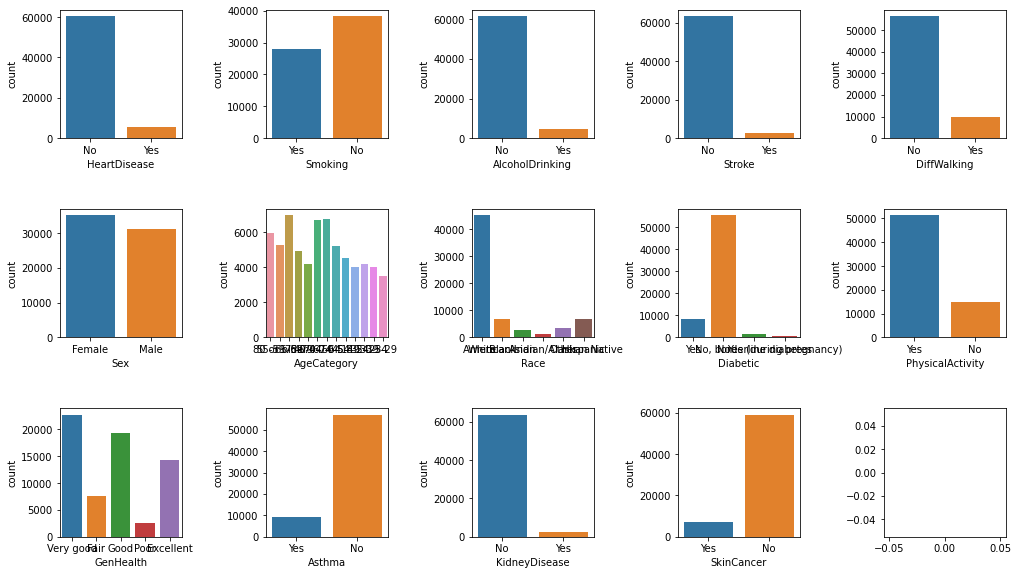

In [266]:
fig, axes = plt.subplots(3, 5)
fig.set_size_inches(15, 9)
fig.tight_layout(pad=5)
k = 0

for cat_var in categorical_variables:
    k = int( categorical_variables.index(cat_var)/5 )
    sns.countplot(data[cat_var], ax=axes[k, categorical_variables.index(cat_var)%5])

plt.plot()
plt.show()

**Correlation analysis**

Data encoding.

In [267]:
data["Diabetic"].unique()

array(['Yes', 'No', 'No, borderline diabetes', 'Yes (during pregnancy)',
       nan], dtype=object)

In [268]:
data["Diabetic"] = data["Diabetic"].replace(
    {
        "Yes" : 3,
        "Yes (during pregnancy)" : 2,
        "No, borderline diabetes" : 1,
        "No" : 1
    }
)

In [269]:
data["GenHealth"].unique()

array(['Very good', 'Fair', 'Good', 'Poor', 'Excellent', nan],
      dtype=object)

In [270]:
data["GenHealth"] = data["GenHealth"].replace(
    {
        'Excellent' : 4,
        'Very good' : 3,
        'Good' : 2,
        'Fair' : 1,
        'Poor' : 0
    }
)

In [271]:
unencoded_cat_var = list(set(categorical_variables) - set(["Diabetic", "GenHealth"]))
data[unencoded_cat_var].head()

,Sex,Stroke,AgeCategory,Smoking,DiffWalking,AlcoholDrinking,Asthma,KidneyDisease,SkinCancer,HeartDisease,Race,PhysicalActivity
0,Female,No,55-59,Yes,No,No,Yes,No,Yes,No,White,Yes
1,Female,Yes,80 or older,No,No,No,No,No,No,No,White,Yes
2,Male,No,65-69,Yes,No,No,Yes,No,No,No,White,Yes
3,Female,No,75-79,No,No,No,No,No,Yes,No,White,No
4,Female,No,40-44,No,Yes,No,No,No,No,No,White,Yes


In [272]:
# cat_var_bin_encoding = list(set(unencoded_cat_var)-set(["AgeCategory", "Race"]))
for cat_var in list(set(unencoded_cat_var)-set(["AgeCategory", "Race"])):
    if cat_var=="Sex":
        data[cat_var] = data[cat_var].replace({"Male" : 1, "Female" : 0})
    else:
        data[cat_var] = data[cat_var].replace({"Yes" : 1, "No" : 0})
data[list(set(unencoded_cat_var)-set(["AgeCategory", "Race"]))].head()

,Sex,Stroke,Smoking,DiffWalking,AlcoholDrinking,Asthma,KidneyDisease,SkinCancer,HeartDisease,PhysicalActivity
0,0,0,1,0,0,1.0,0.0,1.0,0,1.0
1,0,1,0,0,0,0.0,0.0,0.0,0,1.0
2,1,0,1,0,0,1.0,0.0,0.0,0,1.0
3,0,0,0,0,0,0.0,0.0,1.0,0,0.0
4,0,0,0,1,0,0.0,0.0,0.0,0,1.0


In [273]:
for cat_var in ["AgeCategory", "Race"]:
    data[cat_var] = data[cat_var].replace(dict([ (i, data[cat_var].unique().tolist().index(i)) for i in data[cat_var].unique() ]))
data[["AgeCategory", "Race"]]

,AgeCategory,Race
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
66305,7,0
66306,12,4
66307,10,2
66308,5,0


In [274]:
encd_cat = data[categorical_variables]
encd_cat.head()

,HeartDisease,Smoking,AlcoholDrinking,Stroke,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,Asthma,KidneyDisease,SkinCancer
0,0,1,0,0,0,0,0,0,3.0,1.0,3.0,1.0,0.0,1.0
1,0,0,0,1,0,0,1,0,1.0,1.0,3.0,0.0,0.0,0.0
2,0,1,0,0,0,1,2,0,3.0,1.0,1.0,1.0,0.0,0.0
3,0,0,0,0,0,0,3,0,1.0,0.0,2.0,0.0,0.0,1.0
4,0,0,0,0,1,0,4,0,1.0,1.0,3.0,0.0,0.0,0.0


In [275]:
categorical_variables

['HeartDisease',
 'Smoking',
 'AlcoholDrinking',
 'Stroke',
 'DiffWalking',
 'Sex',
 'AgeCategory',
 'Race',
 'Diabetic',
 'PhysicalActivity',
 'GenHealth',
 'Asthma',
 'KidneyDisease',
 'SkinCancer']

In [276]:
corr_matrix_data_pack = [[data[i].corr(data[j]) if i!=j else 1 for j in categorical_variables] for i in categorical_variables]

<AxesSubplot:>

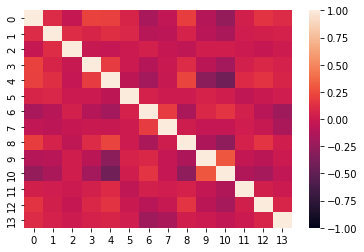

In [277]:
sns.heatmap(corr_matrix_data_pack, vmin=-1, vmax=1)

Correlation matrix shows categorical parameters are bad-correlated.

# Part 3. Numerical data EDA

**General info**

In [278]:
numerical_variables = list( set(data.columns) - set(categorical_variables) )
num = pd.DataFrame(numerical_variables)
num = data.select_dtypes('number')
print(numerical_variables)
print(f"Numerical variables number: {len(numerical_variables)}")

['SleepTime', 'PhysicalHealth', 'MentalHealth', 'BMI']
Numerical variables number: 4


In [279]:
num

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,16.60,1,0,0,3.0,30.0,0,0,0,0,3.0,1.0,3.0,5.0,1.0,0.0,1.0
1,0,20.34,0,0,1,0.0,0.0,0,0,1,0,1.0,1.0,3.0,7.0,0.0,0.0,0.0
2,0,26.58,1,0,0,20.0,30.0,0,1,2,0,3.0,1.0,1.0,8.0,1.0,0.0,0.0
3,0,24.21,0,0,0,0.0,0.0,0,0,3,0,1.0,0.0,2.0,6.0,0.0,0.0,1.0
4,0,23.71,0,0,0,28.0,0.0,1,0,4,0,1.0,1.0,3.0,8.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66305,0,28.06,1,0,0,0.0,0.0,0,1,7,0,1.0,1.0,4.0,7.0,0.0,0.0,0.0
66306,0,29.05,0,0,0,0.0,15.0,0,0,12,4,1.0,1.0,3.0,7.0,1.0,0.0,0.0
66307,0,23.40,1,1,0,0.0,0.0,0,1,10,2,1.0,1.0,4.0,5.0,0.0,0.0,0.0
66308,0,32.50,1,0,0,0.0,0.0,1,1,5,0,3.0,0.0,2.0,9.0,0.0,0.0,0.0


**Visualization**

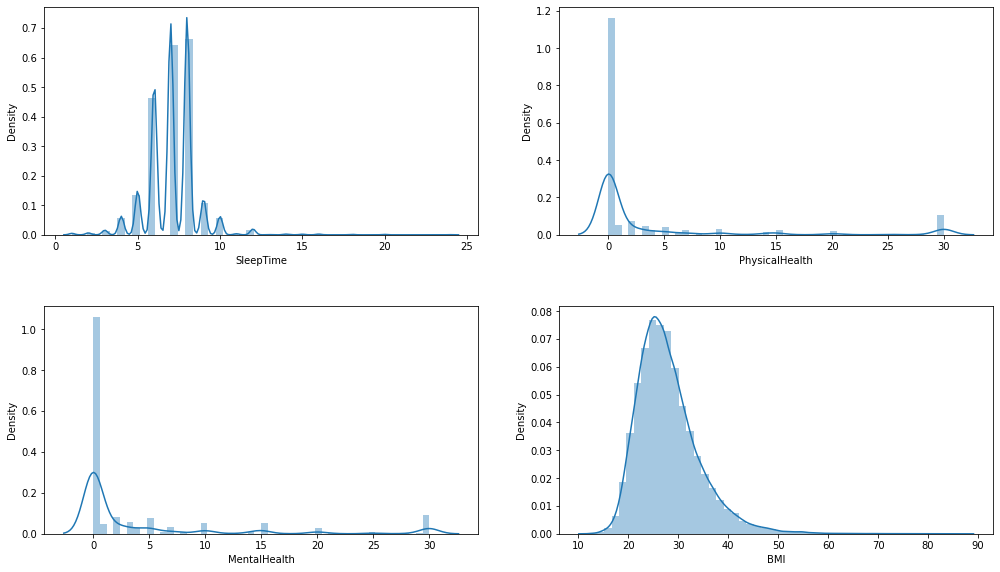

In [280]:
fig, axes = plt.subplots(2, 2)
fig.set_size_inches(15, 9)
fig.tight_layout(pad=5)
k = 0

for num_var in numerical_variables:
    k = int(numerical_variables.index(num_var)/2)
    sns.distplot(data[num_var], ax=axes[k, numerical_variables.index(num_var)%2])

plt.plot()
plt.show()

**Correlation analysis**

In [281]:
corr_matrix_data_pack = [[data[i].corr(data[j]) if i!=j else 1 for j in numerical_variables] for i in numerical_variables]

<AxesSubplot:>

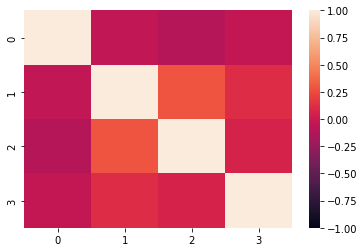

In [282]:
sns.heatmap(corr_matrix_data_pack, vmin=-1, vmax=1)

In [283]:
data1 = num   # since it contains also the encoded categorical variables 

In [284]:
data1.columns.value_counts()

HeartDisease        1
BMI                 1
KidneyDisease       1
Asthma              1
SleepTime           1
GenHealth           1
PhysicalActivity    1
Diabetic            1
Race                1
AgeCategory         1
Sex                 1
DiffWalking         1
MentalHealth        1
PhysicalHealth      1
Stroke              1
AlcoholDrinking     1
Smoking             1
SkinCancer          1
dtype: int64

In [285]:
print(data1['Sex'])
data1['Sex'] = data1['Sex'].replace({'Mal':1})

0        0
1        0
2        1
3        0
4        0
        ..
66305    1
66306    0
66307    1
66308    1
66309    0
Name: Sex, Length: 66310, dtype: int64


In [286]:
data1

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,0,16.60,1,0,0,3.0,30.0,0,0,0,0,3.0,1.0,3.0,5.0,1.0,0.0,1.0
1,0,20.34,0,0,1,0.0,0.0,0,0,1,0,1.0,1.0,3.0,7.0,0.0,0.0,0.0
2,0,26.58,1,0,0,20.0,30.0,0,1,2,0,3.0,1.0,1.0,8.0,1.0,0.0,0.0
3,0,24.21,0,0,0,0.0,0.0,0,0,3,0,1.0,0.0,2.0,6.0,0.0,0.0,1.0
4,0,23.71,0,0,0,28.0,0.0,1,0,4,0,1.0,1.0,3.0,8.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66305,0,28.06,1,0,0,0.0,0.0,0,1,7,0,1.0,1.0,4.0,7.0,0.0,0.0,0.0
66306,0,29.05,0,0,0,0.0,15.0,0,0,12,4,1.0,1.0,3.0,7.0,1.0,0.0,0.0
66307,0,23.40,1,1,0,0.0,0.0,0,1,10,2,1.0,1.0,4.0,5.0,0.0,0.0,0.0
66308,0,32.50,1,0,0,0.0,0.0,1,1,5,0,3.0,0.0,2.0,9.0,0.0,0.0,0.0


In [287]:
data1.isna().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            1
PhysicalActivity    1
GenHealth           1
SleepTime           1
Asthma              1
KidneyDisease       1
SkinCancer          1
dtype: int64

In [288]:
imputer = SimpleImputer(missing_values=np.NAN, strategy='most_frequent', fill_value='F')
data1.Diabetic = imputer.fit_transform(data1['Diabetic'].values.reshape(-1,1))[:,0]
data1.PhysicalActivity = imputer.fit_transform(data1['PhysicalActivity'].values.reshape(-1,1))[:,0]
data1.GenHealth = imputer.fit_transform(data1['GenHealth'].values.reshape(-1,1))[:,0]
data1.Asthma = imputer.fit_transform(data1['Asthma'].values.reshape(-1,1))[:,0]
data1.KidneyDisease = imputer.fit_transform(data1['KidneyDisease'].values.reshape(-1,1))[:,0]
data1.SkinCancer = imputer.fit_transform(data1['SkinCancer'].values.reshape(-1,1))[:,0]
imputer_num = SimpleImputer(missing_values=np.NaN, strategy='mean')
data1.SleepTime = imputer_num.fit_transform(data1['SleepTime'].values.reshape(-1,1))[:,0]

In [289]:
data1.isna().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

# Extracting X and y

In [290]:
X = data1.drop(['HeartDisease'], 1)
y = data1.HeartDisease

# Splitting into train and test

In [291]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/3, random_state = 0)

# Building Models

## KNN MODEL

In [292]:
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train, y_train)
knn_ypred = knn.predict(X_test)

In [293]:
acc_knn = accuracy_score(y_test,knn_ypred)
acc_knn

0.9130926529134998

In [294]:
f1_score(y_test,knn_ypred)

0.05416051206302314

In [295]:
print(classification_report(y_test,knn_ypred))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95     20236
           1       0.34      0.03      0.05      1868

    accuracy                           0.91     22104
   macro avg       0.63      0.51      0.50     22104
weighted avg       0.87      0.91      0.88     22104



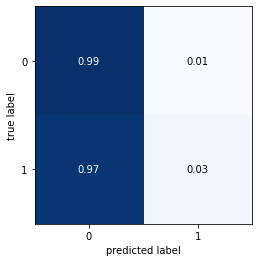

In [296]:
conf_mat = confusion_matrix(y_test, knn_ypred)

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                figsize=(6, 4))
fig.show()


## LOGISTIC REGRESSION

In [297]:
lor = LogisticRegression(max_iter=1000)
lor.fit(X_train, y_train)
lor_ypred = lor.predict(X_test)

In [298]:
acc_lor = accuracy_score(y_test,lor_ypred)
acc_lor

0.9151284835323923

In [299]:
f1_score(y_test,lor_ypred)

0.16843971631205673

In [300]:
print(classification_report(y_test,lor_ypred))

              precision    recall  f1-score   support

           0       0.92      0.99      0.96     20236
           1       0.49      0.10      0.17      1868

    accuracy                           0.92     22104
   macro avg       0.71      0.55      0.56     22104
weighted avg       0.89      0.92      0.89     22104



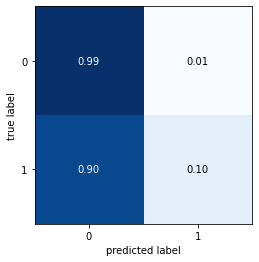

In [301]:
conf_mat = confusion_matrix(y_test, lor_ypred)

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                figsize=(6, 4))
fig.show()

## GAUSSIAN-NB MODEL

In [302]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)
gnb_ypred = gnb.predict(X_test)

In [303]:
acc_gnb = accuracy_score(y_test,gnb_ypred)
acc_gnb

0.8457745204487875

In [304]:
f1_score(y_test,gnb_ypred)

0.3507903256522567

In [305]:
print(classification_report(y_test,gnb_ypred))

              precision    recall  f1-score   support

           0       0.95      0.88      0.91     20236
           1       0.27      0.49      0.35      1868

    accuracy                           0.85     22104
   macro avg       0.61      0.69      0.63     22104
weighted avg       0.89      0.85      0.87     22104



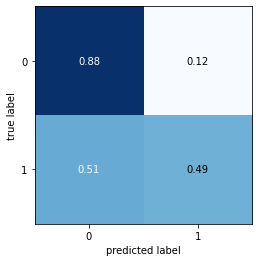

In [306]:
conf_mat = confusion_matrix(y_test, gnb_ypred)

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                figsize=(6, 4))
fig.show()

## XG-Boost MODEL

In [307]:
xgb = XGBClassifier(learning_rate=0.1, n_estimators=100,random_state=5)
xgb.fit(X_train, y_train)
xgb_ypred = xgb.predict(X_test)

In [308]:
acc_xgb = accuracy_score(y_test,xgb_ypred)
acc_xgb

0.9161690191820485

In [309]:
f1_score(y_test,xgb_ypred)

0.17239839213934793

In [310]:
print(classification_report(y_test,xgb_ypred))

              precision    recall  f1-score   support

           0       0.92      0.99      0.96     20236
           1       0.52      0.10      0.17      1868

    accuracy                           0.92     22104
   macro avg       0.72      0.55      0.56     22104
weighted avg       0.89      0.92      0.89     22104



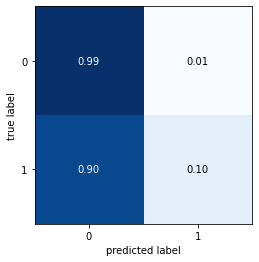

In [311]:
conf_mat = confusion_matrix(y_test, xgb_ypred)

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                figsize=(6, 4))
fig.show()

## RANDOM FOREST MODEL

In [312]:
rfc = RandomForestClassifier(n_estimators=50,max_depth=10,random_state=100,criterion='gini')
rfc.fit(X_train, y_train)
rfc_ypred = rfc.predict(X_test)

In [313]:
acc_rfc = accuracy_score(y_test,xgb_ypred)
acc_rfc

0.9161690191820485

In [314]:
f1_score(y_test,rfc_ypred)

0.08871365204534253

In [315]:
print(classification_report(y_test,xgb_ypred))

              precision    recall  f1-score   support

           0       0.92      0.99      0.96     20236
           1       0.52      0.10      0.17      1868

    accuracy                           0.92     22104
   macro avg       0.72      0.55      0.56     22104
weighted avg       0.89      0.92      0.89     22104



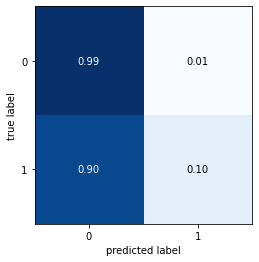

In [316]:
conf_mat = confusion_matrix(y_test, xgb_ypred)

fig, ax = plot_confusion_matrix(conf_mat=conf_mat,
                                show_normed=True,
                                show_absolute=False,
                                figsize=(6, 4))
fig.show()

## COMPARE ALL MODEL

In [317]:
results = pd.DataFrame({
    'Model': ['KNN', 'Logistic Regression', 'Naive Bayes', 
              'XGBoost', 'Random Forest'],
    'Score': [acc_knn, acc_lor, acc_gnb, acc_xgb, acc_rfc]})
   
result_df = results.sort_values(by='Score', ascending=False)
result_df = result_df.set_index('Model')
result_df

,Score
Model,
XGBoost,0.916169
Random Forest,0.916169
Logistic Regression,0.915128
KNN,0.913093
Naive Bayes,0.845775
